In [183]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import time
import jsonlines
from PIL import Image
from scipy.optimize import curve_fit
import scipy as sy
import pickle as pkl
import seaborn as sns
from os.path import join as oj
import sklearn.model_selection
import sklearn.linear_model
import numpy.linalg as npl
import pandas as pd
import viz
from tqdm import tqdm
from scipy import optimize
import scipy.stats
import torch
import models
import util
import style

PROCESSED_DIR = 'processed'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading

**load gt latents**

In [2]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))

**load annotations in different directions**

In [3]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
attrs = ['age', 'facial-hair', 'skin-color', 'gender', 'hair-length', 'makeup']
N = len(attrs)

In [40]:
attr_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in attrs]).transpose()
attr_mat = (attr_mat - attr_mat.mean(axis=0)) / attr_mat.std(axis=0)

In [41]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        latents, attr_mat, test_size=0.3, random_state=42)

In [42]:
n_train = X_train.shape[0]
latent_dim = X_train.shape[1]
n_attr = y_train.shape[1]
W = np.zeros((latent_dim, n_attr))

# fit with penalty

In [250]:
def calc_mean_corrs_between_attributes(A: torch.Tensor):
    '''Calculate mean correlation off-diagonal
    A: torch.Tensor
        attributes (num_samples, num_attributes)
    '''
    num = A.shape[1]
    corr = 0
    for i in range(num):
        for j in range(i):
            corr += torch.abs(util.pearsonr(y_pred[:, i], y_pred[:, j]))
    return corr / ((num * (num - 1)) / 2)

def loss_with_indep(y_pred, y_true, reg_param=1):
    corr = calc_mean_corrs_between_attributes(y_pred)
    mse = torch.mean(torch.square(y_pred - y_true))
    return mse + reg_param * corr

# setup
m = models.LinearNet(num_layers=1, input_size=X_train.shape[1], output_size=y_train.shape[1]) # linear reg
# m = models.LinearNet(num_layers=3, input_size=X_train.shape[1], output_size=y_train.shape[1], hidden_size=100)
X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

optimizer = torch.optim.SGD(m.parameters(), lr = 1e-2)

# fit
class s:
    epochs = []
    mse = []
    spearman = []
    indep_corr = []
    mse_test = []
    spearman_test = []
    indep_corr_test = []
    reg_param = []
    
    def _dict(self):
        return {attr: val for (attr, val) in vars(s).items()
                 if not attr.startswith('_')}

def detach(tensor):
    return tensor.detach().cpu().numpy()
    
reg_param = 1e-5
EPOCHS_PER_RUN = 2500
EPOCHS = EPOCHS_PER_RUN * 15
for epoch in range(EPOCHS): 
    y_pred = m(X_train_t)
    y_pred_test = m(X_test_t)
    loss = loss_with_indep(y_pred, y_train_t, reg_param=reg_param) 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch % EPOCHS_PER_RUN == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item())) 
        
        # params
        s.epochs.append(epoch)
        s.reg_param.append(reg_param)
        reg_param *= 5
        
        # training
        s.mse.append(detach(torch.mean(torch.square(y_pred - y_train_t))))
        s.spearman.append(scipy.stats.spearmanr(y_pred[:, i].detach().numpy(),
                                                y_train[:, i]).correlation)
        s.indep_corr.append(detach(calc_mean_corrs_between_attributes(y_pred)))
        
        # testing
        s.mse_test.append(detach(torch.mean(torch.square(y_pred_test - y_test_t))))
        s.spearman_test.append(scipy.stats.spearmanr(y_pred_test[:, i].detach().numpy(),
                                                     y_test[:, i]).correlation)
        s.indep_corr_test.append(detach(calc_mean_corrs_between_attributes(y_pred_test)))

# save results as dataframe
s_dict = s._dict(s)
df = pd.DataFrame.from_dict(s_dict)
# df.to_pickle(oj(PROCESSED_DIR, '06_df_loss_tradeoff_nonlinear.pkl'))
# df.to_pickle(oj(PROCESSED_DIR, '06_df_loss_tradeoff`_nonlinear.pkl'))

epoch 0, loss 1.0141410827636719
epoch 2500, loss 0.2993755042552948
epoch 5000, loss 0.22302047908306122
epoch 7500, loss 0.1864088475704193
epoch 10000, loss 0.1636005938053131
epoch 12500, loss 0.15372680127620697
epoch 15000, loss 0.17692212760448456
epoch 17500, loss 0.27505719661712646
epoch 20000, loss 0.3717971444129944
epoch 22500, loss 0.7773498296737671
epoch 25000, loss 1.8666318655014038
epoch 27500, loss nan
epoch 30000, loss nan
epoch 32500, loss nan
epoch 35000, loss nan


/Users/snghzqx/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/snghzqx/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/snghzqx/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes 

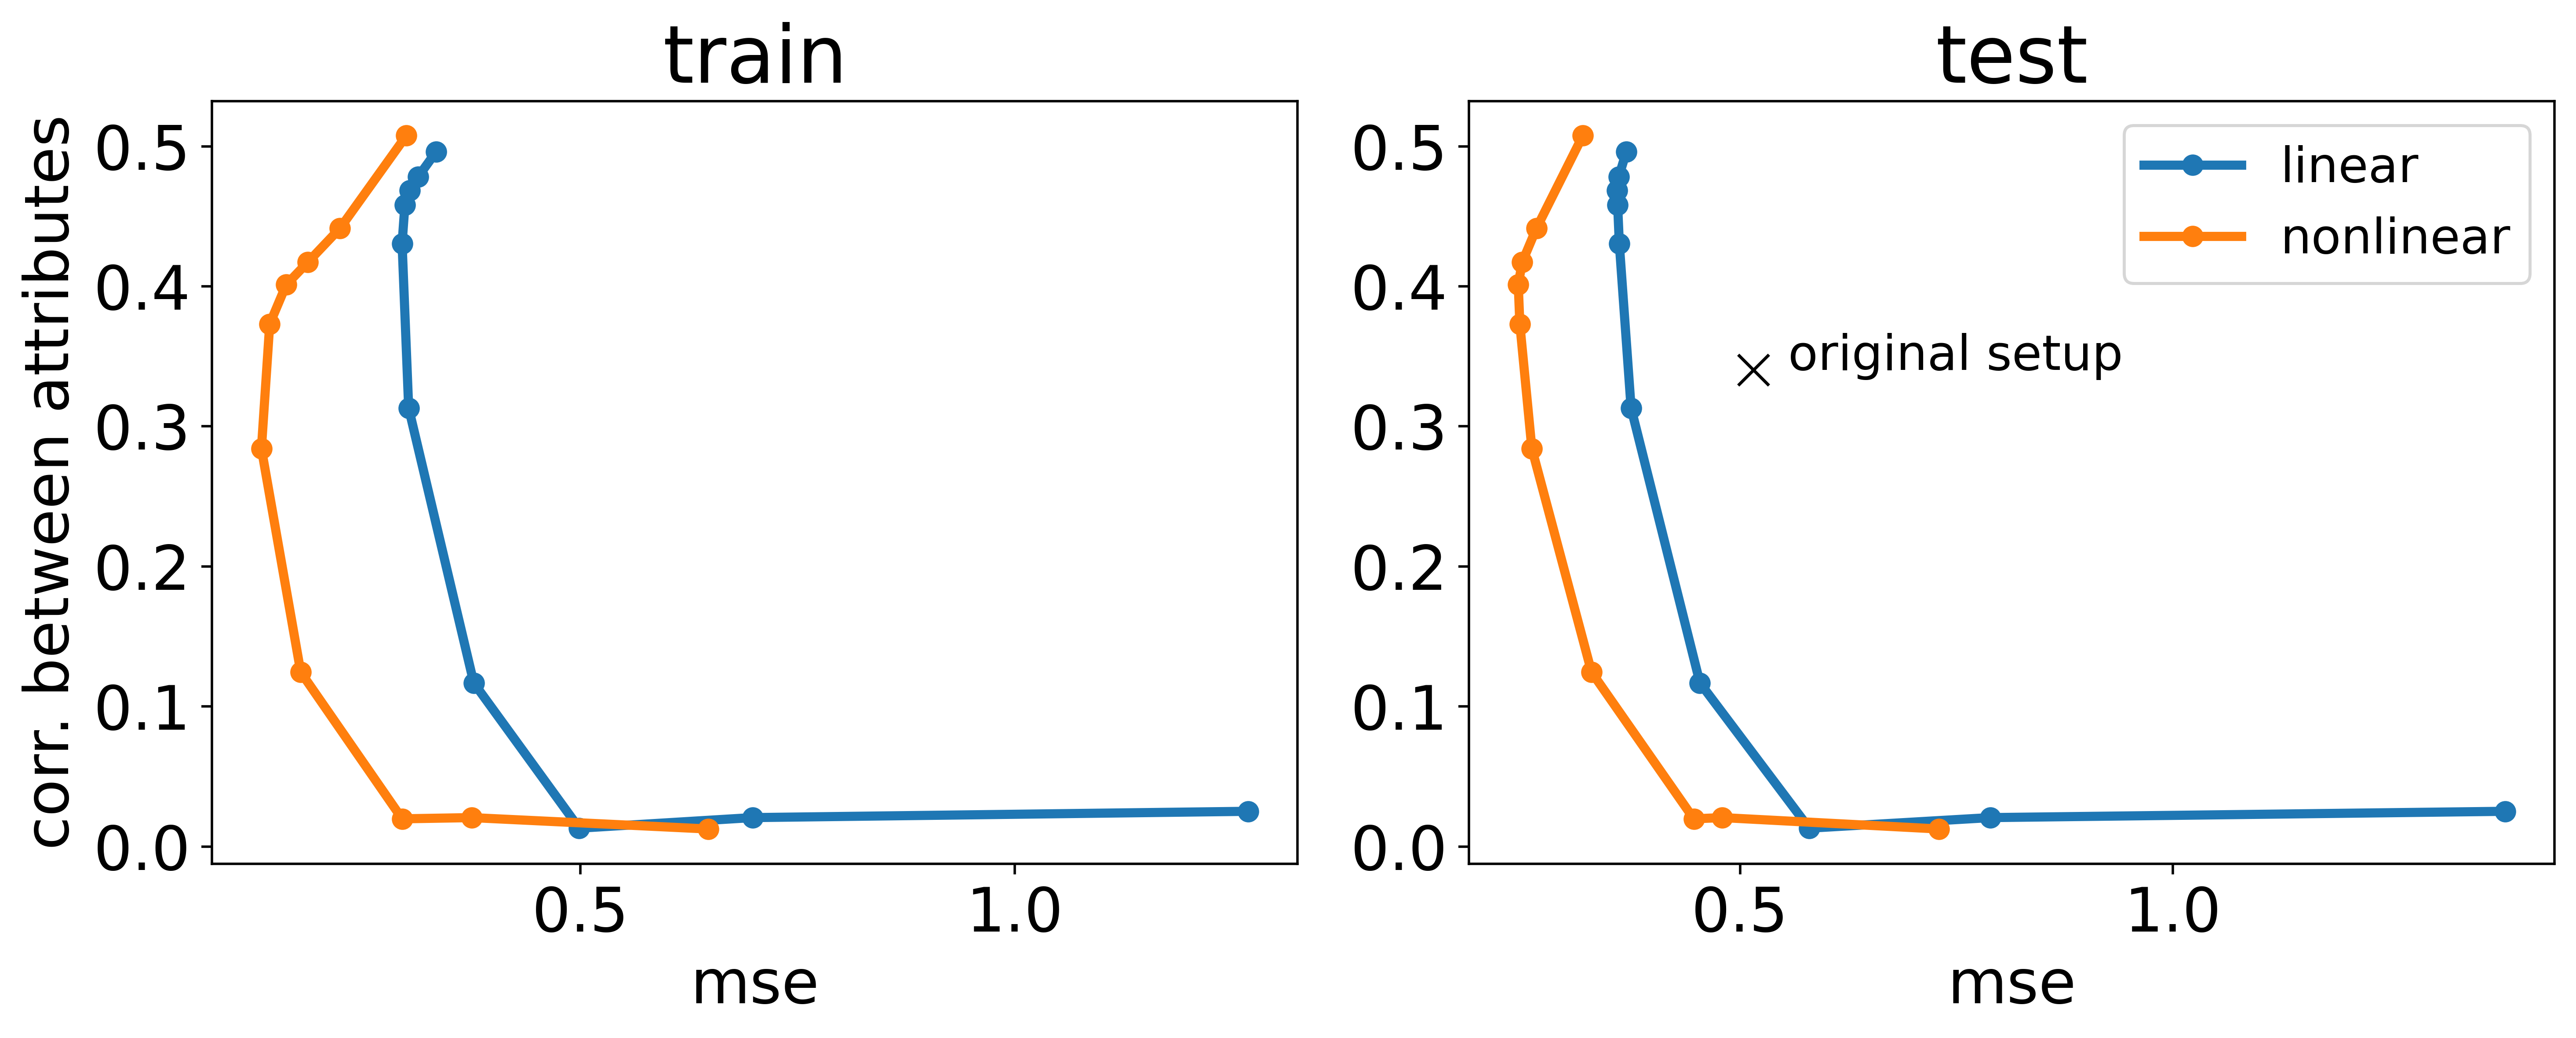

In [277]:
# linear plots
df = pd.read_pickle(oj(PROCESSED_DIR, '06_df_loss_tradeoff_linear.pkl'))
df = df.iloc[1:]
df = df.iloc[:-4]
R, C = 1, 2
plt.figure(figsize=(12, 5), dpi=500)
plt.subplot(R, C, 1)
plt.plot(df['mse'], df['indep_corr'], 'o-', label='linear')
plt.xlabel('mse')
plt.ylabel('corr. between attributes')
plt.title('train')

ax = plt.subplot(R, C, 2)
plt.plot(df['mse_test'], df['indep_corr_test'], 'o-', label='linear')
plt.xlabel('mse')
plt.title('test')

# nonlinear plots
df2 = pd.read_pickle(oj(PROCESSED_DIR, '06_df_loss_tradeoff_nonlinear.pkl'))
df2 = df2.iloc[1:]
df2 = df2.iloc[:-3]

plt.subplot(R, C, 1)
plt.plot(df2['mse'], df2['indep_corr'], 'o-', label='nonlinear')
plt.xlabel('mse')
plt.ylabel('corr. between attributes')
plt.title('train')

ax = plt.subplot(R, C, 2)
plt.plot(df2['mse_test'], df2['indep_corr_test'], 'o-', label='nonlinear')
plt.xlabel('mse')
plt.title('test')

# previous 
plt.subplot(R, C, 2)
MSE_ORIG = 0.51532
CORR_ORIG = 0.340195386
plt.plot(MSE_ORIG, CORR_ORIG, 'x', color='black', ms=10)
ax.annotate('original setup', (MSE_ORIG + 0.04, CORR_ORIG), color='black')
plt.legend()
plt.tight_layout()

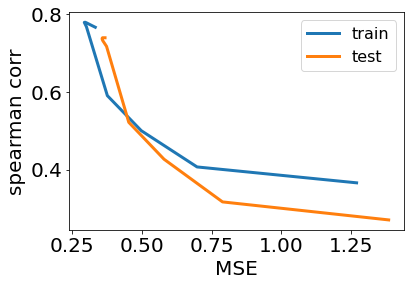

In [249]:
plt.plot(df['mse'], df['spearman'], label='train')
plt.plot(df['mse_test'], df['spearman_test'], label='test')
plt.xlabel('MSE')
plt.ylabel('spearman corr')
plt.legend()
plt.show()

In [128]:
preds_train = m(torch.Tensor(X_train)).detach().numpy()
preds_test = m(torch.Tensor(X_test)).detach().numpy()
print('shapes', preds_train.shape, preds_test.shape)

shapes (3500, 6) (1500, 6)


-0.06701056051352683
-0.0560786178909151
-0.007059932797258937
0.05037832516859507
0.03442539077078464
-0.03800710654858129


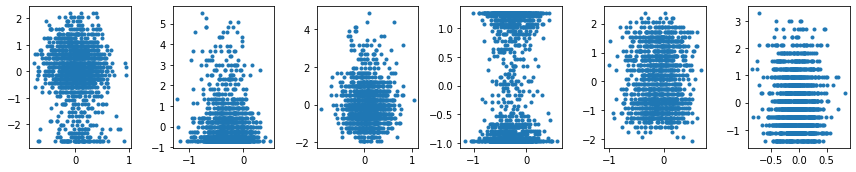

In [129]:
R, C = 1, 6
plt.figure(figsize=(12, 2.5))
for i in range(6):
    plt.subplot(R, C, i + 1)
    plt.plot(preds_test[:, i], y_test[:, i], '.')
    print(scipy.stats.spearmanr(preds_test[:, i], y_test[:, i]).correlation)

plt.tight_layout()
plt.show()

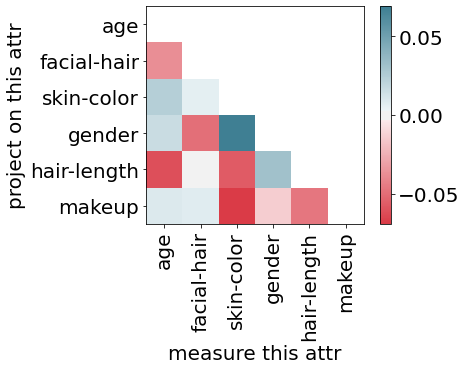

In [135]:
viz.corrplot(np.corrcoef(preds_test.transpose()))
plt.xticks(range(N), attrs, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N), attrs)
plt.colorbar()
plt.show()